In [73]:
import pandas as pd
import numpy  
import tensorflow as tf
import math
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
# from keras.layers.normalization import BatchNormalization
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

configpartno='85-EKA0190'
# configpartno='85-EKA0190'



In [92]:
def readTrain():
    train =  pd.read_csv("./data/Parts_EQP_Output_ByMonth_20210407_van.csv")
    train= train[train['PART_NO']==configpartno]  
    train.drop(columns=['PART_NO','EQP_NO','MFG_MONTH','PM','TS','ENG','NST'],inplace=True)
    train = train.groupby(['STOCK_EVENT_TIME']).sum().reset_index()
    train['STOCK_EVENT_TIME'] =train['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))
    train = train.sort_values('STOCK_EVENT_TIME')

    return train

In [75]:
# LSTM for international airline passengers problem with regression framing

# 產生 (X, Y) 資料集, Y 是下一期的乘客數
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [76]:

# print(dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))>=  pd.to_datetime('2021-01-01')].shape)
# print(dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))<  pd.to_datetime('2021-01-01')].shape)

In [107]:

# 載入訓練資料
#dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataframe = readTrain()
dataset = dataframe['QTY']
dataset = dataset.astype('float32')

In [108]:
dataset =dataset.values.reshape(-1,1)

In [109]:

# 正規化(normalize) 資料，使資料值介於[0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [80]:
# 2/3 資料為訓練資料， 1/3 資料為測試資料
# train_size = int(len(dataset) * 0.67)
# test_size = len(dataset) - train_size

# train_size = dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))<  pd.to_datetime('2021-01-01')].shape[0]
# train_size = dataframe[dataframe['STOCK_EVENT_TIME'] >=  pd.to_datetime('2021-01-01')].shape[0]

In [134]:
# 2/3 資料為訓練資料， 1/3 資料為測試資料
# train_size = int(len(dataset) * 0.67)
# test_size = len(dataset) - train_size

# train_size = dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))<  pd.to_datetime('2021-01-01')].shape[0]
train_size = dataframe[dataframe['STOCK_EVENT_TIME'] <  pd.to_datetime('2020-10-01')].shape[0]
# test_size =  dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))>=  pd.to_datetime('2021-01-01')].shape[0]
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print('split:',train_size,test_size)

# 產生 (X, Y) 資料集, Y 是下一期的乘客數(reshape into X=t and Y=t+1)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


split: 69 6


In [116]:
print(len(train))
print(len(trainX))

72
70


In [117]:
print(len(test))
print(len(testX))

5
3


In [10]:

# 建立及訓練 LSTM 模型
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
model = tf.keras.Sequential([
            tf.keras.layers.LSTM(units=4, input_shape=(1, look_back)),
            tf.keras.layers.Dense(units=1),
            ]) 
model.compile(loss='mean_squared_error', 
            optimizer=tf.keras.optimizers.Adam(),
            # metrics=[tf.keras.metrics.MeanAbsoluteError()]
            ) 
model.summary()
train_history =model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Train on 574 samples
Epoch 1/100
574/574 - 5s - loss: 0.0483
Epoch 2/100
574/574 - 2s - loss: 0.0209
Epoch 3/100
574/574 - 1s - loss: 0.0132
Epoch 4/100
574/574 - 1s - loss: 0.0120
Epoch 5/100
574/574 - 1s - loss: 0.0118
Epoch 6/100
574/574 - 1s - loss: 0.0117
Epoch 7/100
574/574 - 1s - loss: 0.0118
Epoch 8/100
574/574 - 1s - loss: 0.0117
Epoch 9/100
574/574 - 1s - loss: 0.0118
Epoch 10/100
574/574 - 1s - loss: 0.0116
Epoch 11/100
574/574 - 1s - loss: 0.0118
Epoch 12/100
574/574 - 1s - loss: 0.0117
Epoch 13/100
574

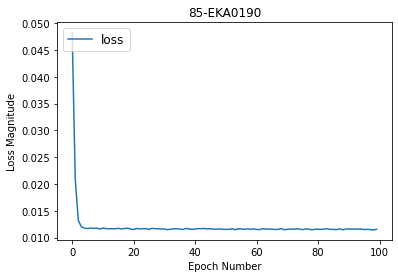

In [135]:
figure, axis_1 = plt.subplots()
plt.title(configpartno) # title
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")

loss = axis_1.plot(train_history.history['loss'], label = 'loss')

#axis_2 = axis_1.twinx()

#mse = axis_2.plot(train_history.history['mse'], label = 'mse',color='red' ) 
        
axis_1.legend(loc='upper left',fontsize='large')
#axis_2.legend(loc='upper right',fontsize='large')
# plt.legend((ac, valloss, mse, mape),
#        ('Low accuracy', 'val_loss', 'mse', 'mape'),
#        scatterpoints=1,
#        loc='upper right',
#     #    ncol=3,
#        fontsize=14)

plt.show()

In [136]:
# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [137]:
# nsamples, nx, ny = train_dataset.shape
# d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))

In [138]:

# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

In [139]:

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [140]:
#calculate 均方根誤差(root mean squared error)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 32.14 RMSE
Test Score: 18.57 RMSE


In [363]:
testPredict

array([[39.66279  ],
       [39.66279  ],
       [21.228624 ],
       [26.049417 ],
       [ 2.9985387],
       [11.707069 ],
       [26.049417 ],
       [30.77999  ],
       [30.77999  ],
       [35.338528 ],
       [30.77999  ],
       [30.77999  ],
       [26.049417 ],
       [21.228624 ],
       [26.049417 ],
       [30.77999  ],
       [16.413769 ],
       [16.413769 ],
       [16.413769 ],
       [16.413769 ],
       [21.228624 ],
       [16.413769 ]], dtype=float32)

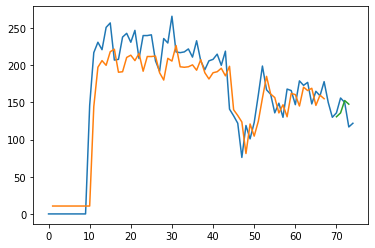

In [141]:

# 畫訓練資料趨勢圖
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 畫原始資料趨勢圖
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [145]:


# trainPredictPlot[np.isnan(trainPredictPlot)] = 0  # replace all nan in a with 0
# testPredictPlot[np.isnan(testPredictPlot)] = 0  # replace all nan in b with 0
# numpy.add(trainPredictPlot, testPredictPlot) 
# dataframe_test = dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))<  pd.to_datetime('2021-01-01')]
dataframe_test = dataframe.copy(deep = False)

In [297]:
# numpy.nan_to_num(testPredict) 

array([[39.114334 ],
       [39.114334 ],
       [20.729734 ],
       [25.50046  ],
       [ 2.0950081],
       [11.191733 ],
       [25.50046  ],
       [30.188925 ],
       [30.188925 ],
       [34.74143  ],
       [30.188925 ],
       [30.188925 ],
       [25.50046  ],
       [20.729734 ],
       [25.50046  ],
       [30.188925 ],
       [15.938207 ],
       [15.938207 ],
       [15.938207 ],
       [15.938207 ],
       [20.729734 ],
       [15.938207 ]], dtype=float32)

In [146]:
dataframe_test =  dataframe_test[dataframe_test['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))>=  pd.to_datetime('2021-01-01')]

In [147]:
dataframe_test.tail(10)

,STOCK_EVENT_TIME,QTY
72,2021-01-31,150
73,2021-02-28,117
74,2021-03-31,122


In [44]:

dataframe_test.iloc[1:dataframe_test.shape[0]-1].tail()

,STOCK_EVENT_TIME,QTY
3672,2021-01-31,5
3673,2021-02-28,5
3674,2021-03-31,0
3747,2021-01-31,15
3748,2021-02-28,5


In [150]:
def accsum(def_result,target_cols):
        _accsum=0 
        for index,row in def_result.iterrows():
            #避免當分母為0 會無法計算
            if row[target_cols]==0 and row['Predict']==0 :
                row[target_cols] =1
                row['Predict'] =1
            elif row[target_cols] ==0 and row['Predict']!=0:
                row[target_cols]  =0.00001

            if row[target_cols] <0 :
                row[target_cols]  =0.00001

            if row['Predict'] <0 :
                row['Predict']  =0 

            if 1- abs((row['Predict'] - row[target_cols])/row[target_cols] ) >0 : 
                _accsum+=(1- abs((row['Predict'] - row[target_cols])/row[target_cols] ))
        
        return round(_accsum*100/def_result.shape[0],2)

In [286]:
dataframe_test.to_csv('./Data/LSTM_{}.csv'.format(configpartno), index=False)

In [287]:
dataframe_test

,STOCK_EVENT_TIME,QTY,Predict
3222,2021-01-31,21,NaN
3223,2021-02-28,17,NaN
3224,2021-03-31,17,NaN
3297,2021-01-31,5,NaN
3298,2021-02-28,5,NaN
3299,2021-03-31,5,NaN
3372,2021-01-31,9,NaN
3373,2021-02-28,0,NaN
3374,2021-03-31,5,NaN
3447,2021-01-31,5,NaN


In [288]:
accsum(dataframe_test,'QTY')

2.58

In [160]:
train_all

,PART_NO,EQP_NO,STOCK_EVENT_TIME,QTY,PM,TS,ENG,NST,MFG_MONTH
72,85-ECT0010,ECT11,2021-01-31,4,4.0,0.0,0.0,0.0,202101
73,85-ECT0010,ECT11,2021-02-28,3,3.0,0.0,0.0,0.0,202102
74,85-ECT0010,ECT11,2021-03-31,4,4.0,0.0,0.0,0.0,202103
147,85-ECT0010,ECT12,2021-01-31,5,5.0,0.0,0.0,0.0,202101
148,85-ECT0010,ECT12,2021-02-28,5,5.0,0.0,0.0,0.0,202102
...,...,...,...,...,...,...,...,...,...
20698,85-EMA0920,EWA52,2021-02-28,0,0.0,0.0,0.0,0.0,202102
20699,85-EMA0920,EWA52,2021-03-31,1,1.0,0.0,0.0,0.0,202103
20772,85-EMA0920,EWA53,2021-01-31,0,0.0,0.0,0.0,0.0,202101
20773,85-EMA0920,EWA53,2021-02-28,0,0.0,0.0,0.0,0.0,202102


# 計算平均值 準確率

In [183]:
train_all['QTY'].mean()

503.0833333333333

In [184]:
partList =['85-ECT0010','85-EKA0190','85-EKA0270','85-EMA0130','85-EMA0900','85-EMA0910','85-EMA0920','86-DIA0120','87-WPT1070']
train_all =  pd.read_csv("./data/Parts_EQP_Output_ByMonth_20210407_van.csv")
train_all = train_all[train_all['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))>=  pd.to_datetime('2020-01-01')]
train_all = train_all[train_all['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))<  pd.to_datetime('2021-01-01')]

for p in partList:
    train= train_all[train_all['PART_NO']==p]  
    train.drop(columns=['PART_NO','EQP_NO','STOCK_EVENT_TIME','PM','TS','ENG','NST'],inplace=True)
    train = train.groupby(['MFG_MONTH']).sum().reset_index()
    
    # train['STOCK_EVENT_TIME'] =train['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))
    # train = train.sort_values('STOCK_EVENT_TIME')
    train['Predict'] = train['QTY'].mean()
    print(p,accsum(train,'QTY'))
    # print(train.head())


85-ECT0010 97.6
85-EKA0190 91.17
85-EKA0270 75.01
85-EMA0130 72.12
85-EMA0900 59.72
85-EMA0910 35.01
85-EMA0920 57.62
86-DIA0120 32.31
87-WPT1070 36.92
C:\ProgramData\Anaconda3\envs\PY379\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [167]:
# partList =['85-ECT0010','85-EKA0190','85-EKA0270','85-EMA0130','85-EMA0900','85-EMA0910','85-EMA0920','86-DIA0120','87-WPT1070']
# train_all =  pd.read_csv("./data/Parts_EQP_Output_ByMonth_20210407_van.csv")
# train_all = train_all[train_all['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))>=  pd.to_datetime('2021-01-01')]
# for p in partList:
#     train= train_all[train_all['PART_NO']==p]  
#     # train.drop(columns=['PART_NO','EQP_NO','MFG_MONTH','PM','TS','ENG','NST'],inplace=True)
#     # train = train.sum()
    
#     # train['STOCK_EVENT_TIME'] =train['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))
#     # train = train.sort_values('STOCK_EVENT_TIME')
#     # train['Predict'] = train['QTY'].mean()
#     # print(p,accsum(train,'QTY'))
#     def_result_summary = df2[[config.targetCol,'Predict']].sum()
#     qtymean = def_result_summary['QTY'].mean()
#     totol_acc = (1- abs(qtymean -train['QTY'])/train['QTY'])*100
#     print(mlKind+" Test Mean (%f) acc :%f  ", (qtymean ,totol_acc))
    

NameError: name 'qtymean' is not defined